<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for Hydrological Streamline Detection Using a U-net Model with Attention Module</h1>
<p style="text-align:center;font-size:12px;">
$Zewei$ $Xu^{1,2}$; $Shaowen$ $Wang^{1,2}$; $Lawrence V.$ $Stanislawski^{3}$; $Zhe$ $Jiang^{4}$; $Nattapon$ $Jaroenchai^{1,2}$; $Arpan Man$ $Sainju^{4}$; $Ethan$ $Shavers^{3}$; $E. Lynn$ $Usery^{3}$; $Li$ $Chen^{2,5}$; $Zhiyu$ $Li^{1,2}$; $Bin$ $Su^{1,2}$
</p>
<p style="text-align:center;font-size:12px;">
$^{1}$$Department$ $of$ $Geography$ $and$ $Geographic$ $Information$ $Science$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{2}$$CyberGIS$ $Center$ $for$ $Advanced$ $Digital$ $and$ $Spatial$ $Studies$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{3}$$U.S.$ $Geological$ $Survey$, $Center$ $of$ $Excellence$ $for$ $Geospatial$ $Information$ $Science$, $Rolla$, $MO$, $USA$<br>
$^{4}$$Department$ $of$ $Computer$ $Science$, $University$ $of$ $Alabama$, $Tuscaloosa$, $AL$, $USA$<br>
$^{5}$$School$ $of$ $Geosciences$ $and$ $Info-Physics$, $Central$ $South$ $University$, $Changsha$, $Hunan$, $China$<br>
$Corresponding$ $Author:$ $nj7@illinois.edu$
</p>

---
    
**Notebook Structure:**  
[1. Introduction](1_Introduction.ipynb)  
2. Codes   
 [2.1. Data Preprocessing](2.1_Code_Data_Preprocessing.ipynb)  
 [2.2. Model Training](2.2_Code_Model_Training.ipynb)  
 [2.3. Interpret the Result](2.3_Code_Interpret_the_Result%20.ipynb)   

---

### Introduction

Surface water is an irreplaceable strategic resource for human survival and social development. Accurate delineation of hydrologic streamlines, which represent one of the major forms of land surface water, is critically important for various scientific disciplines, such as water resources assessment, climate modelling, agricultural suitability, river dynamics, wetland inventory, watershed analysis, surface water surveying and management, flood mapping, and environmental monitoring. Traditional hydrological models depend largely on topographic information, which inevitably contain errors. For example, when deriving drainage lines from elevation, dry drainage channels are likely to be falsely recognized as streamlines, and roads or bridges can act as barriers forcing flowlines along the roadway rather than under the bridge or through a culvert. Traditional methods also generally ignore the information about the complex 3D environment of stream channels as well as surface reflectance, which is potentially very useful for accurately delineating streamlines. In recent years, the availability of high accuracy LiDAR data provides a promising method to capture both the 3D environment structure and the land surface reflectance information. Terrestrial LiDAR sensors use NIR light in the form of a pulsed laser to measure range (variable distances) to a surface and reflectance intensity for multiple returns. These light pulses generate precise, three-dimensional information about the shape and characteristics of reflecting surfaces. In this research, multiple LiDAR features maps are generated, and we developed a deep learning model based on the U-Net architecture and attention mechanism for streamline detection. We also compared the deep learning model with several traditional machine learning methods as baseline. An advanced cyberinfrastructure is used for computing power and CyberGIS-Jupyter is applied for research reproducibility. An accuracy evaluation indicates the attention U-net model outperforms the best baseline method by 8.08% on average by F1-score, and it provides better smoothness and connectivity over the predicted streamlines.


### Research Objectives
- To implement a U-Net Convolutional Neural Network model with attention module on cyberinfrastructure to identify streamlines and diffuse knowledge (reproducibility!)
- To understand the role of parameterization in model performance
- To compare the results and accuracy from the U-Net CNN model with those from traditional methods for streamline identification
- Build the foundation for a model that can more accurately and efficiently identify streamlines and is scalable (replicability!)
- Further the discourse of R&R in CyberGIScience, and develop lifelong collaborative partners and friends


---
### Input Dataset

**Data format:** las (raw LiDAR data),tiff (feature maps), and numpy array (organized data)

  - **Panther_LiDAR:** Store LiDAR point cloud data (.las) (e.g. IA_Statewide_2008_009081.las, naming format: State_projection_year_pathlines)

  - **Rowan_LiDAR:** Store LiDAR point cloud data (e.g. 0_1.las, naming forma8: row_number+column_number from the top-left corner of the research area), organized LiDAR feature maps and reference data under data folde under data folder.

  - **mask.npy:** The mask of research area. 1 indicates research area. 0 indicates outside area.

  - **reference.npy:** numpy array format of reference data. 1 indicates streamlines, 0 indicates non-streamlines

  - **total.npy:** total prediction data of all feature maps

  - **TIFF:** All of the feature maps are derived from the ground return of LiDAR point clouds:

    **(1) DEM(digital elevation model):** a 1-m resolution digital elevation model (DEM) derived from the ground return points.

    **(2) Curvature map:** geometric curvature determined from the DEM. Geometric curvature is determined using GeoNet software (Sangireddy, et al., 2016). The software applies the non-linear diffusion Perona-Malik filter on the DEM to remove noise and sharpen the localization of channels (Passalacqua et al., 2010).

    **(3) TPI1:** a topographic position index (TPI) derived from the DEM using a 3-cell by 3-cell window. The TPI value of a cell is the difference between the cell elevation and the local average elevation within a specific radius or within a surrounding window of cells (De Reu et al., 2013).

    **(4) TPI2:** a TPI derived from the DEM using a 21-cell by 21-cell window.

    **(5) Geomorphon openness:** zenith angle openness derived from the DEM using a 10-cell radius with 32 directions (Doneus, 2013).

    **(6) Intensity:** return intensity determined from the lidar ground points averaged with inverse distance weighting using 10 nearest points.

    **(7) DSM1:** point density for return points between zero and 1 foot above ground.

    **(8) DSM2:** point density for return points between 0 and 3 feet above ground.

curvature, DSM1 (digital surface model with 1feet below), DSM2 (digital surface model with 3feet below), geomorphon openness, LiDAR ground reflectance, TPI1 (topological position index with 21 moving window size), TPI2 (topological position index with 3 moving window size), reference image.

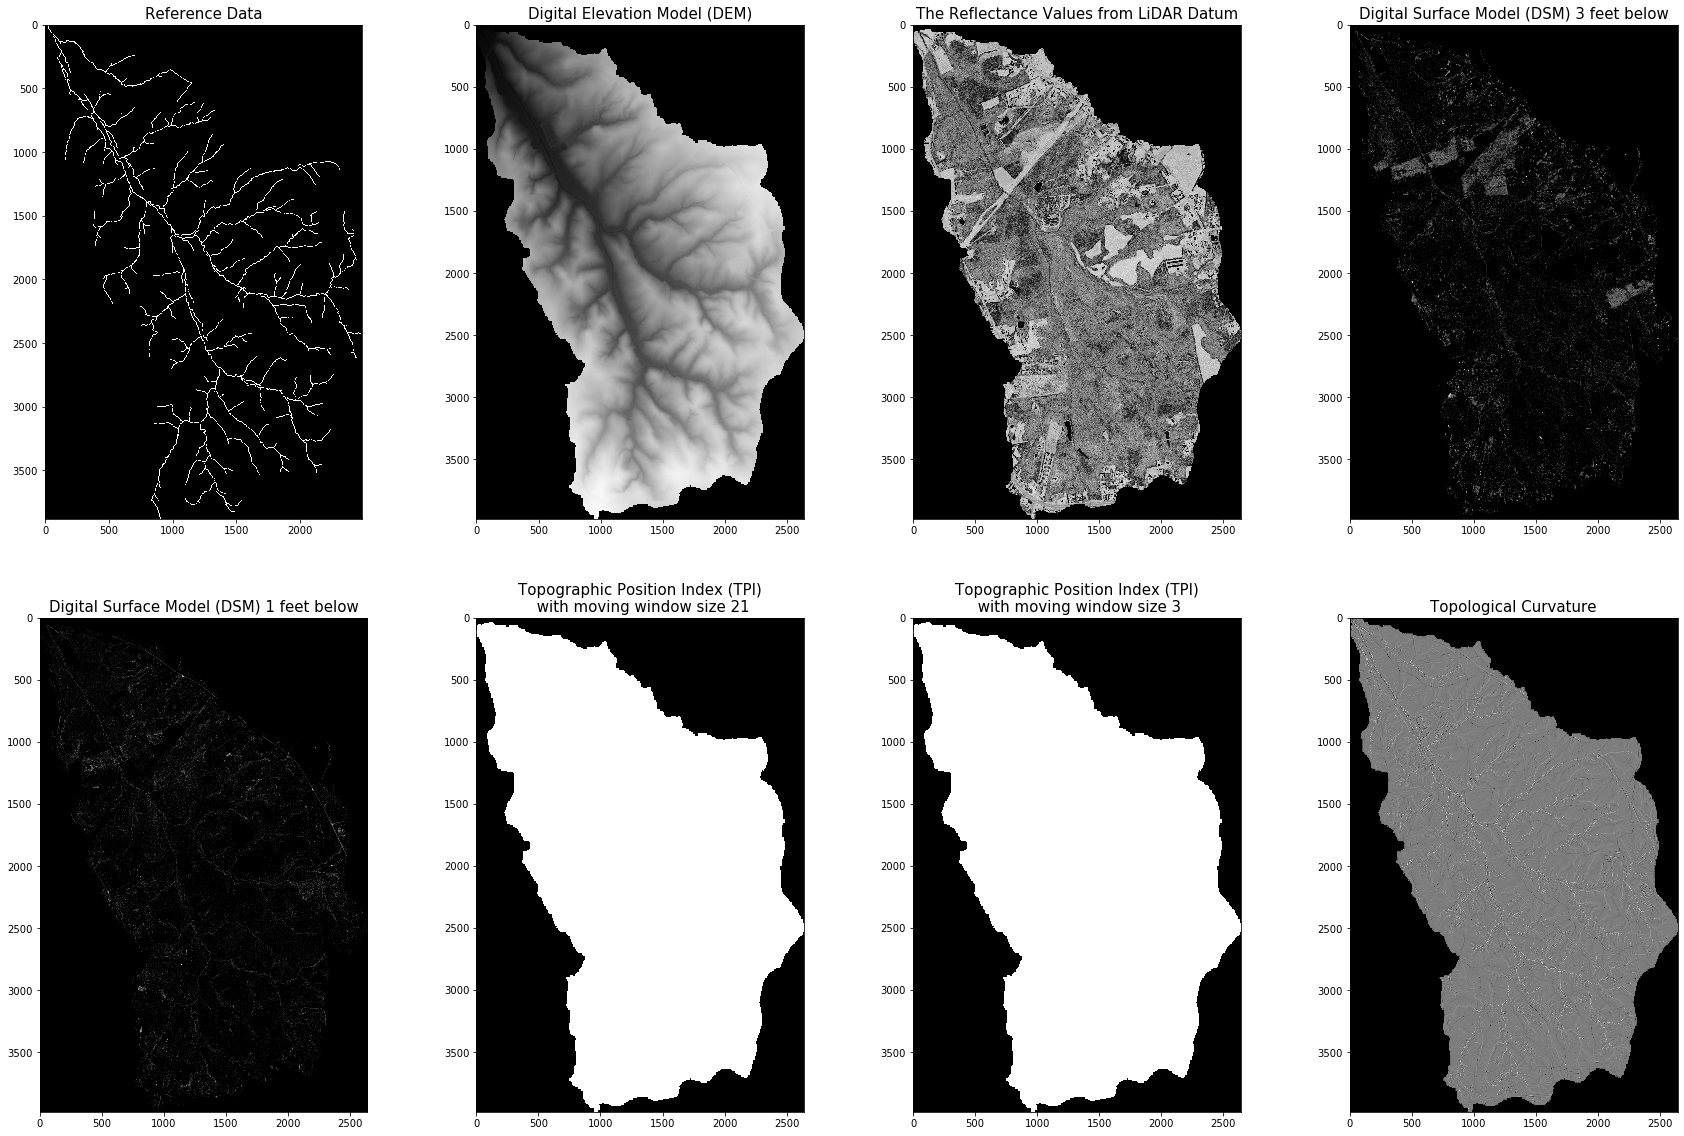

In [12]:
## Visualization of reference data
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
import os.path
from os import path

root="/home/jovyan/shared_data/data/unet_streamline_detection/"

counter = 0
#Label for each image
labels = ["Reference Data",
         "Digital Elevation Model (DEM)",
         "The Reflectance Values from LiDAR Datum",
         "Digital Surface Model (DSM) 3 feet below", 
         "Digital Surface Model (DSM) 1 feet below",
         "Topographic Position Index (TPI)\n with moving window size 21",
         "Topographic Position Index (TPI)\n with moving window size 3",
         "Topological Curvature",
         "Geomorphon Openness"]

#The path to the TIF files
feats_name = [root+'data/TIFF/reference.tif',
              root+'data/TIFF/DEM.tif',
              root+'data/TIFF/LiDAR_relectance.tif',
              root+'data/TIFF/DSM_3ft_below.tif',
              root+'data/TIFF/DSM_1ft_below.tif',
              root+'data/TIFF/TPI_ws21_Clip21.tif',
              root+'data/TIFF/TPI_ws3_Clip1.tif',
              root+'data/TIFF/Curvature.tif',
              root+'data/TIFF/Geomorphon.tif']


fig, axes = plt.subplots(2,4, figsize=(30,20))
for i,ax in enumerate(axes.flat):
    ds = gdal.Open(feats_name[i])
    data = ds.GetRasterBand(1).ReadAsArray()
    ax.imshow(data,cmap='gray')
    ax.set_title(labels[i], fontsize=15)
